(400, 881)


'分析小结\n    由上面实验结果可知，当steps的值越来越大，步长越来越大时，噪点的存在就越来越少，\n    实验图片中的物体纹理愈发明显，但是会丧失许多细节，图片画面过于平滑。所以步长应取适中，以下实验取为20。\n\n    由上图的实验结果可以看到，当随着窗口大小不断增大时，可以看到视差图的噪点不断减少，\n    并且图片的细节也不断变少，实验图片中含有的具体细节都有被一定的平滑抹去掉，\n    但由于窗口增大后的边缘逐渐模糊，也更有利于我们判断物体边缘。所以可以显而易见地得出对于wid的取值，\n    我们应该要视情况而定，一般取适中即可，不可过大或过小。\n    并且，在匹配算法是我们追求的更多是对于位置特征的准确性，需要较多的细节，所以wid取值可以偏小，大约为10即可。\n'

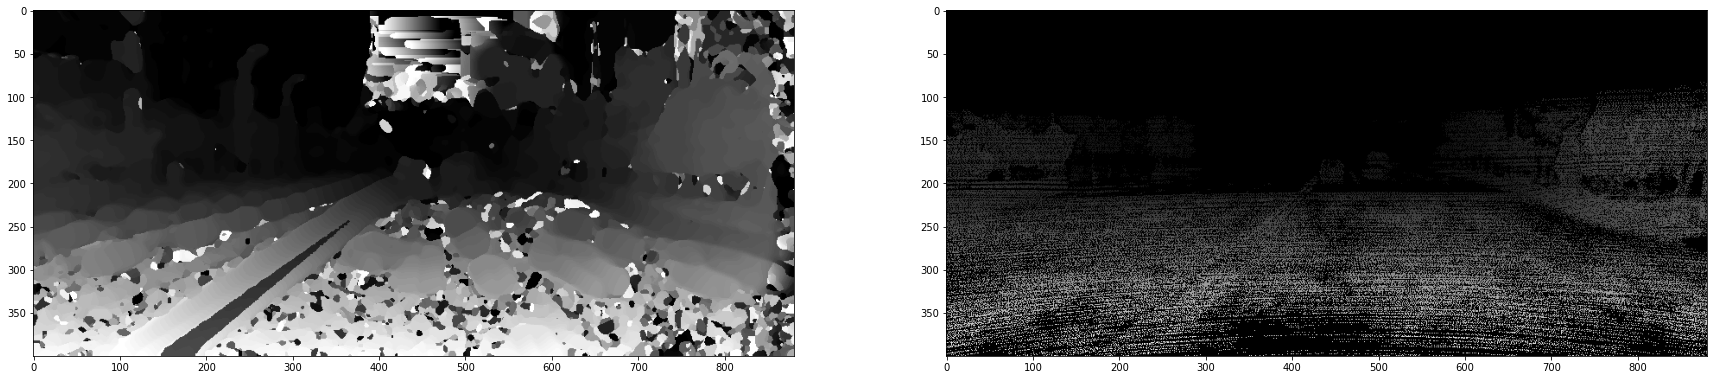

In [197]:
from PIL import Image
from pylab import *
import numpy as np
from numpy.ma import array
from scipy import ndimage
import cv2
from matplotlib import pyplot as plt


def NCC_UniformFilter(im_l,im_r,start,steps,wid):
    """ 使用归一化的互相关计算视差图像 """
    m,n = im_l.shape
    # 保存不同求和值的数组
    mean_l = np.zeros((m,n))
    mean_r = np.zeros((m,n))
    s = np.zeros((m,n))
    s_l = np.zeros((m,n))
    s_r = np.zeros((m,n))
    # 保存深度平面的数组
    dmaps = np.zeros((m, n, steps * 4))
    # 计算图像块的平均值
    ndimage.uniform_filter(im_l,wid,mean_l)
    ndimage.uniform_filter(im_r,wid,mean_r)
    # 归一化图像
    norm_l = im_l - mean_l
    norm_r = im_r - mean_r
    #steps = np.arange(0,68,0.25) 
    
    # 尝试不同的视差
    count = 0
    for displ in range(steps):
        # 将左边图像移动到右边，计算加和
        #shiftImg = np.roll(norm_l, int(round(-displ - start, 0)))
        shiftImg = np.roll(norm_l, -displ - start, 0)
        ndimage.uniform_filter(shiftImg * norm_r, wid, s) # 和归一化
        ndimage.uniform_filter( shiftImg *  shiftImg, wid, s_l)
        ndimage.uniform_filter(norm_r*norm_r,wid,s_r) # 和反归一化
        # 保存 ncc 的分数
        dmaps[:,:,count] = s / sqrt(abs(s_l * s_r))
        count+=1
        # 为每个像素选取最佳深度
    return np.argmax(dmaps, axis=2)


def NCC_Gauss(im_l,im_r,start,steps,wid):
 """ 使用带有高斯加权周边的归一化互相关计算视差图像 """
 m,n = im_l.shape
 # 保存不同加和的数组
 mean_l = np.zeros((m,n))
 mean_r = np.zeros((m,n))
 s = np.zeros((m,n))
 s_l = np.zeros((m,n))
 s_r = np.zeros((m,n))
 # 保存深度平面的数组
 dmaps = np.zeros((m,n,steps))
 # 计算平均值
 ndimage.gaussian_filter(im_l,wid,0,mean_l)
 ndimage.gaussian_filter(im_r,wid,0,mean_r)
 # 归一化图像
 norm_l = im_l - mean_l
 norm_r = im_r - mean_r
 # 尝试不同的视差
 for displ in range(steps):
     # 将左边图像移动到右边，计算加和
     shiftImg = np.roll(norm_l, -displ - start)
     ndimage.gaussian_filter(shiftImg * norm_r, wid, 0, s) # 和归一化
     ndimage.gaussian_filter(shiftImg * shiftImg, wid, 0, s_l)
     ndimage.gaussian_filter(norm_r*norm_r,wid,0,s_r) # 和反归一化
     # 保存 ncc 的分数
     dmaps[:,:,displ] = s / np.sqrt(s_l * s_r)
 # 为每个像素选取最佳深度
 return np.argmax(dmaps, axis=2)

im_l = cv2.imread("./resources/Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg",cv2.IMREAD_GRAYSCALE)
im_r = cv2.imread("./resources/Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg",cv2.IMREAD_GRAYSCALE)

print(im_l.shape)

im_l = array(im_l,'f')
im_r = array(im_r,'f')
# 开始偏移，并设置步长
steps = 68
start = 1
# ncc 的宽度
windowSize = 4

#disparityMap = NCC_UniformFilter(im_l,im_r,start,steps,windowSize)
disparityMap = NCC_Gauss(im_l,im_r,start,steps,windowSize)
disparityMap = cv2.subtract(disparityMap, tuple([1.0]))
disparityMap = cv2.normalize(disparityMap, disparityMap, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX).astype(np.uint8)

plt.subplots(figsize=(30, 30)) 
plt.subplot(1,2,1)
plt.imshow(disparityMap, cmap="gray")

groundTruth = cv2.imread('./resources/Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png')
groundTruth = cv2.normalize(groundTruth, groundTruth, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
plt.subplot(1,2,2)
plt.imshow(groundTruth)
#print(groundTruth[:,:,0][380])


"""分析小结
    由上面实验结果可知，当steps的值越来越大，步长越来越大时，噪点的存在就越来越少，
    实验图片中的物体纹理愈发明显，但是会丧失许多细节，图片画面过于平滑。所以步长应取适中，以下实验取为20。

    由上图的实验结果可以看到，当随着窗口大小不断增大时，可以看到视差图的噪点不断减少，
    并且图片的细节也不断变少，实验图片中含有的具体细节都有被一定的平滑抹去掉，
    但由于窗口增大后的边缘逐渐模糊，也更有利于我们判断物体边缘。所以可以显而易见地得出对于wid的取值，
    我们应该要视情况而定，一般取适中即可，不可过大或过小。
    并且，在匹配算法是我们追求的更多是对于位置特征的准确性，需要较多的细节，所以wid取值可以偏小，大约为10即可。
"""


a. The rms (root mean squared) error between the values in your disparity map and those in the ground truth

In [198]:
groundTruth = cv2.imread(r'resources\Dataset\2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png')
def root_mean_squared_error(img1,img2):
    #判断两张图片的shape是否一致
    if img1.shape != img2.shape:
        print("images have different shape ")
    #计算两张图像的MSE
    img_rmse = np.sqrt(np.mean((img1.astype(np.float64) - img2.astype(np.float64))**2))
    #将图像的MSE量化为相似度
    img_sim = img_rmse / 255
    return img_rmse,1 - img_sim

root_mean_squared_error(groundTruth[:,:,0], disparityMap)

(103.61511100567024, 0.5936662313503127)

b. The fractions of pixels with errors less than 4, 2, 1, 0.5 and 0.25 pixels

In [199]:
def get_fraction(threshhold, imgTruth, img):
    TotalValidPixel = 0
    lessThan4 = 0
    lessThan2 = 0
    lessThan0_5 = 0
    lessThan0_25 = 0

    for y in range(len(imgTruth)):
        for x in range(len(imgTruth[0])):
            if imgTruth[y][x] != 0:
                TotalValidPixel+=1
                diff = abs(imgTruth[y][x] - img[y][x])
                if diff <= 0.25:
                    lessThan0_25 +=1 
                if diff <= 0.5:
                    lessThan0_5 += 1
                if diff <= 2:
                    lessThan2 += 1
                if diff <= 4:
                    lessThan4 +=1 
    print(lessThan4, lessThan2, lessThan0_5, lessThan0_25, TotalValidPixel)
    return lessThan4/TotalValidPixel, lessThan2/TotalValidPixel, lessThan0_5/TotalValidPixel, lessThan0_25/TotalValidPixel
            
get_fraction(1,groundTruth[:,:,0], disparityMap)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17160\4186069593.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  diff = abs(imgTruth[y][x] - img[y][x])


399 241 76 76 88149


(0.004526426845454855,
 0.002734007192367469,
 0.000862176541991401,
 0.000862176541991401)